In [1]:
import torch
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt

In [24]:
device = torch.device("cuda:0")

In [3]:
import torch
from torch import nn

class AutoEncoder(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        # self.encoder = nn.Sequential(
        #     nn.Conv2d(1, 16, 3, padding='same'),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #     nn.Conv2d(16, 16, 3, padding='same'),
        #     nn.ReLU(),
        #     nn.Conv2d(16, 16, 3, padding='same'),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #     nn.Conv2d(16, 8, 3, padding='same'),
        #     nn.ReLU(),
        #     nn.Conv2d(8, 8, 3, padding='same'),
        #     nn.ReLU(),
        #     nn.MaxPool2d(2, 2),
        #     nn.Flatten(),
        #     nn.Linear(3*3*8, 128),
        #     nn.ReLU(),
        #     nn.Linear(128, 36),
        #     nn.ReLU(),
        # )
        # self.decoder = nn.Sequential(
        #     nn.Unflatten(1, (4, 3, 3)),
        #     nn.ConvTranspose2d(4, 8, 3, stride=2, padding=0),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(8, 16, 2, stride=2, padding=0),
        #     nn.ReLU(),
        #     nn.ConvTranspose2d(16, 1, 2, stride=2),
        # )
        # self.encoder = nn.Sequential(
        #             nn.Conv2d(1, 16, 3, padding='same'),
        #             nn.ReLU(),
        #             # # nn.MaxPool2d(2, 2),
        #             nn.Conv2d(16, 16, 3, stride=2),
        #             nn.ReLU(),
        #             nn.Conv2d(16, 16, 3, stride=2),
        #             nn.ReLU(),
        #             # # nn.MaxPool2d(2, 2),
        #             nn.Conv2d(16, 8, 3,  stride=2),
        #             nn.ReLU(),
        #             # nn.Conv2d(8, 8, 3, stride=2),
        #             # nn.ReLU(),
        #             # # nn.MaxPool2d(2, 2),
        #             nn.Flatten(),
        #             nn.Linear(32, 64),
        #             # nn.ReLU(),
        #             nn.Linear(64, 72),
        #             # nn.ReLU(),
        #         )
        # # Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
        # self.decoder = nn.Sequential(
        #             nn.Unflatten(1, (8, 3, 3)),
        #             nn.ConvTranspose2d(8, 16, 3, stride=2, padding=0),
        #             nn.ReLU(),
        #             nn.ConvTranspose2d(16, 32, 2, stride=2, padding=0),
        #             nn.ReLU(),
        #             nn.ConvTranspose2d(32, 1, 2, stride=2),
        #             # nn.Tanh()
        #         )
        self.encoder = torch.nn.Sequential(
            torch.nn.Linear(28 * 28, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 9)
        )
         
        # Building an linear decoder with Linear
        # layer followed by Relu activation function
        # The Sigmoid activation function
        # outputs the value between 0 and 1
        # 9 ==> 784
        self.decoder = torch.nn.Sequential(
            torch.nn.Linear(9, 18),
            torch.nn.ReLU(),
            torch.nn.Linear(18, 36),
            torch.nn.ReLU(),
            torch.nn.Linear(36, 64),
            torch.nn.ReLU(),
            torch.nn.Linear(64, 128),
            torch.nn.ReLU(),
            torch.nn.Linear(128, 28 * 28),
            torch.nn.Sigmoid()
        )
# Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [340]:
import matplotlib.pyplot as plt

In [4]:

transform=transforms.Compose([
    transforms.ToTensor(),
    # transforms.Normalize((0.1307,), (0.3081,)),
    transforms.Lambda(lambda x: x.view(-1))
    ])
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)

dataset2 = datasets.MNIST('./data', train=False, transform=transform)
train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 128}
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)


In [26]:
100000 / len(train_loader)

213.21961620469082

In [5]:
# def train(model, device, train_loader, optimizer, epoch):

from tqdm import tqdm 
model = AutoEncoder().to(device)
# Adadelta : failed
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
total_epoch = 40
eval_every = 10
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, (data, target) in enumerate(bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data, target in bar_eval:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

[TRAIN]:Epoch 39 Loss 0.0256: 100%|██████████| 469/469 [00:09<00:00]


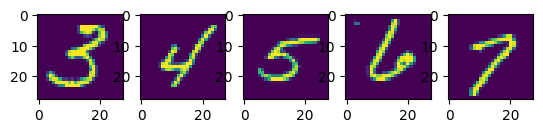

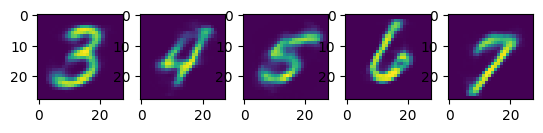

In [16]:
def plotn(n, x):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        ax[i].imshow(z.reshape(28,28) if z.size==28*28 else z.reshape(14,14) if z.size==14*14 else z)
    plt.show()
data_ = data.cpu().numpy()
data_[0:5].shape
output_ = output.detach().cpu().numpy()
output_[0:5].shape
plotn(5,data_[0:5])
plotn(5,output_[0:5])



In [331]:
input_shape = (1, 28, 28)
encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, padding='same'),
            nn.ReLU(),
            # # nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 16, 3, stride=2),
            nn.ReLU(),
            nn.Conv2d(16, 16, 3, stride=2),
            nn.ReLU(),
            # # nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 8, 3,  stride=2),
            nn.ReLU(),
            # nn.Conv2d(8, 8, 3, stride=2),
            # nn.ReLU(),
            # # nn.MaxPool2d(2, 2),
            nn.Flatten(),
            nn.Linear(32, 64),
            # nn.ReLU(),
            nn.Linear(64, 72),
            # nn.ReLU(),
        )
# Hout​=(Hin​−1)×stride[0]−2×padding[0]+dilation[0]×(kernel_size[0]−1)+output_padding[0]+1
decoder = nn.Sequential(
            nn.Unflatten(1, (8, 3, 3)),
            nn.ConvTranspose2d(8, 16, 3, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(16, 32, 2, stride=2, padding=0),
            nn.ReLU(),
            nn.ConvTranspose2d(32, 1, 2, stride=2),
            # nn.Tanh()
        )
out_encoder = encoder(torch.randn(3, 1, 28, 28))
print(out_encoder.shape)
out_decoder = decoder(out_encoder)
print(out_decoder.shape)

torch.Size([3, 72])
torch.Size([3, 1, 28, 28])


In [17]:
import torch
from torch import nn

class AutoEncoder_v2(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                    nn.Conv2d(1, 16, 3, padding='same'),
                    nn.ReLU(),
                    # # nn.MaxPool2d(2, 2),
                    nn.Conv2d(16, 16, 3, stride=2),
                    nn.ReLU(),
                    nn.Conv2d(16, 16, 3, stride=2),
                    nn.ReLU(),
                    # # nn.MaxPool2d(2, 2),
                    nn.Conv2d(16, 8, 3,  stride=2),
                    nn.ReLU(),
                    nn.Flatten(),
                    nn.Linear(32, 64),
                    nn.Linear(64, 72),

                )
        self.decoder = nn.Sequential(
                    nn.Unflatten(1, (8, 3, 3)),
                    nn.ConvTranspose2d(8, 16, 3, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(16, 32, 2, stride=2, padding=0),
                    nn.ReLU(),
                    nn.ConvTranspose2d(32, 1, 2, stride=2),
                    nn.Sigmoid()
                    # nn.Tanh()
                )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x


In [22]:
# autoencoder v2, same batch size, same learning rate, same weight decay, epoch 40, eval_every 10

transform=transforms.Compose([
    transforms.ToTensor(),
    ])
dataset1 = datasets.MNIST('./data', train=True, download=True, transform=transform)

dataset2 = datasets.MNIST('./data', train=False, transform=transform)
train_kwargs = {'batch_size': 128}
test_kwargs = {'batch_size': 128}
train_loader = torch.utils.data.DataLoader(dataset1,**train_kwargs)
test_loader = torch.utils.data.DataLoader(dataset2, **test_kwargs)

# def train(model, device, train_loader, optimizer, epoch):

from tqdm import tqdm 
model = AutoEncoder_v2().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
total_epoch = 40
eval_every = 10
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, (data, target) in enumerate(bar):
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data, target in bar_eval:
                data, target = data.to(device), target.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

[TRAIN]:Epoch 39 Loss 0.0157: 100%|██████████| 469/469 [00:09<00:00]


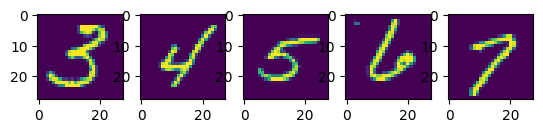

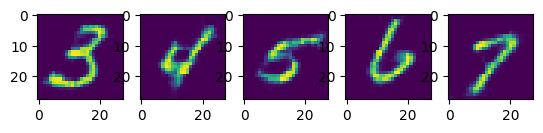

In [23]:
data_ = data.cpu().numpy()
data_[0:5].shape
output_ = output.detach().cpu().numpy()
output_[0:5].shape
plotn(5,data_[0:5])
plotn(5,output_[0:5])

# Denoise MNIST

In [5]:
import torch
from torchvision import datasets, transforms
from torch.utils.data import Dataset, DataLoader

import matplotlib.pyplot as plt
from pathlib import Path
from PIL import Image
from tqdm import tqdm
import torch.optim as optim
import torch.nn.functional as F


In [54]:
from torch import nn

class AutoEncoder_V4_noise(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2),
                nn.ReLU(),
                )
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 5, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 1, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [43]:
class MyMNIST_noise(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(MyMNIST_noise, self).__init__(root, train, transform, target_transform, download)
        self.transforms_noise = transforms.Compose([
            transforms.Lambda(lambda x: torch.clip(x + torch.FloatTensor(x.shape).uniform_(-0.15, 0.15), 0., 1.))
        ])
    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_noise = self.transforms_noise(img)
        return img, img_noise
        
transform=transforms.Compose([
    transforms.ToTensor(),
    ])
dataset1 = MyMNIST_noise('./data', train=True, download=True, transform=transform)

dataset2 = MyMNIST_noise('./data', train=False, transform=transform)


In [44]:
train_loader = DataLoader(dataset1, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset2, batch_size=128, shuffle=False)

In [55]:
from tqdm import tqdm 
model = AutoEncoder_V4_noise().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
total_epoch = 40
eval_every = 10
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, (data, data_noise) in enumerate(bar):
        data, data_noise = data.to(device), data_noise.to(device)
        optimizer.zero_grad()
        output = model(data)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data, data_noise in bar_eval:
                data, data_noise = data.to(device), data_noise.to(device)
                output = model(data)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

  0%|          | 0/469 [00:00<?]

[TRAIN]:Epoch 39 Loss 0.0028: 100%|██████████| 469/469 [00:10<00:00]


In [53]:
encoder = nn.Sequential(
                nn.Conv2d(1, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 3, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 3, stride=2),
                nn.ReLU(),
                )
decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 5, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 1, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
input_shape = (1, 28, 28)
encoder_output = encoder(torch.randn(3, 1, 28, 28))
print(encoder_output.shape)
decoder_output = decoder(encoder_output)
print(decoder_output.shape)

torch.Size([3, 64, 2, 2])
torch.Size([3, 1, 28, 28])


In [46]:
data.shape, data_noise.shape

(torch.Size([128, 1, 28, 28]), torch.Size([128, 1, 28, 28]))

  0%|          | 0/79 [00:00<?]


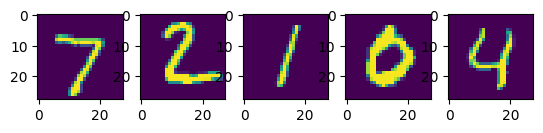

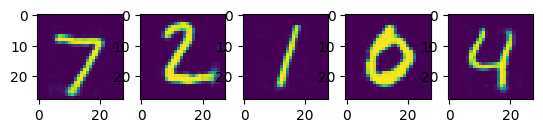

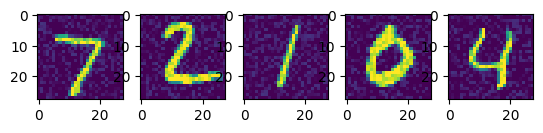

In [59]:
def plotn(n, x, image_shape=(28,28,1)):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(image_shape)
        ax[i].imshow(z_)
    plt.show()

bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
with torch.no_grad():
    for data, data_noise in bar_eval:
        data, data_noise = data.to(device), data_noise.to(device)
        output = model(data)
        break
data_ = data.cpu().numpy()
plotn(5,data_[0:5])
output_ = output.detach().cpu().numpy()
plotn(5,output_[0:5])
data_noise_ = data_noise.cpu().numpy()
plotn(5,data_noise_[0:5])

# Up scale

In [106]:
class AutoEncoder_V4_upscale(nn.Module):
    def __init__(self, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.encoder = nn.Sequential(
                nn.Conv2d(1, 32, 2, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 2, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 2, stride=2),
                nn.ReLU(),
                )
        self.decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 3, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 1, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

In [107]:
class MyMNIST_upscale(datasets.MNIST):
    def __init__(self, root, train=True, transform=None, target_transform=None, download=False):
        super(MyMNIST_upscale, self).__init__(root, train, transform, target_transform, download)
        self.transform_half = transforms.Compose([
                transforms.Resize((14, 14)),
            ])

    def __getitem__(self, index):
        img, target = super().__getitem__(index)
        img_half = self.transform_half(img)
        return img, img_half
        
transform=transforms.Compose([
    transforms.ToTensor(),
    ])
dataset1 = MyMNIST_upscale('./data', train=True, download=False, transform=transform)

dataset2 = MyMNIST_upscale('./data', train=False, transform=transform)


In [108]:
train_loader = DataLoader(dataset1, batch_size=128, shuffle=True)
test_loader = DataLoader(dataset2, batch_size=128, shuffle=False)

In [81]:
bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
for batch_idx, (data, data_half) in enumerate(bar):
    data, data_half = data.to(device), data_half.to(device)
    print(data.shape, data_half.shape)
    break

  0%|          | 0/469 [00:00<?]

torch.Size([128, 1, 28, 28]) torch.Size([128, 1, 14, 14])


In [105]:
encoder = nn.Sequential(
                nn.Conv2d(1, 32, 2, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 32, 2, stride=2),
                nn.ReLU(),
                nn.Conv2d(32, 64, 2, stride=2),
                nn.ReLU(),
                )
decoder = nn.Sequential(
                        nn.ConvTranspose2d(64, 32, 3, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 3, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 32, 2, stride=2, padding=0),
                        nn.ReLU(),
                        nn.ConvTranspose2d(32, 1, 2, stride=2, padding=0),
                        nn.Sigmoid()
                )
# input_shape = (1, 28, 28)
encoder_output = encoder(torch.randn(3, 1, 14, 14))
print(encoder_output.shape)
decoder_output = decoder(encoder_output)
print(decoder_output.shape)

torch.Size([3, 64, 1, 1])
torch.Size([3, 1, 28, 28])


In [111]:
from tqdm import tqdm 
model = AutoEncoder_V4_upscale().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
total_epoch = 40
eval_every = 10
for epoch in range(total_epoch):
    bar = tqdm(train_loader, total=len(train_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=0)
    model.train()
    for batch_idx, (data, data_half) in enumerate(bar):
        data, data_half = data.to(device), data_half.to(device)
        optimizer.zero_grad()
        output = model(data_half)
        loss = F.mse_loss(output, data)
        loss.backward()
        optimizer.step()
        bar.set_description(f'[TRAIN]:Epoch {epoch} Loss {loss.item():.4f}')
    if epoch % eval_every == 0:
        model.eval()
        bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
        with torch.no_grad():
            for data, data_half in bar_eval:
                data, data_half = data.to(device), data_half.to(device)
                output = model(data_half)
                loss = F.mse_loss(output, data)
                bar_eval.set_description(f'[VAL]:Epoch {epoch} Loss {loss.item():.4f}')
        model.train()

  0%|          | 0/469 [00:00<?]/home/thuyentd/miniconda3/envs/CS2310.CH1810.lab5/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
[TRAIN]:Epoch 39 Loss 0.0275: 100%|██████████| 469/469 [00:11<00:00]


  0%|          | 0/79 [00:00<?]


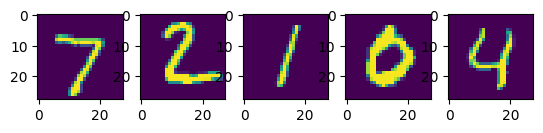

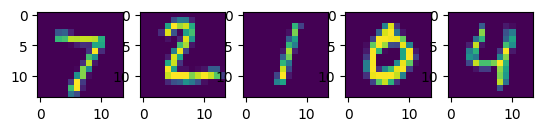

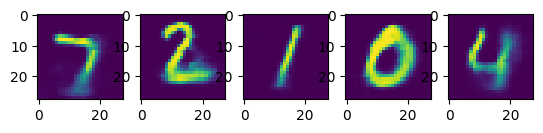

In [118]:
def plotn(n, x, image_shape=(28,28,1)):
    fig, ax = plt.subplots(1, n)
    for i, z in enumerate(x[0:n]):
        z_ = z.reshape(image_shape)
        ax[i].imshow(z_)
    plt.show()

bar_eval = tqdm(test_loader, total=len(test_loader), bar_format='{l_bar}{bar}| {n_fmt}/{total_fmt} [{elapsed}<{remaining}]', leave=True, position=1)
with torch.no_grad():
    for data, data_half in bar_eval:
        data, data_half = data.to(device), data_half.to(device)
        output = model(data_half)
        break
data_ = data.cpu().numpy()
plotn(5,data_[0:5])
data_half_ = data_half.cpu().numpy()
plotn(5,data_half_[0:5], (14,14,1))
output_ = output.detach().cpu().numpy()
plotn(5,output_[0:5], (28,28,1))

In [117]:
output_[0:5].shape

(5, 1, 28, 28)